#  Convolutional Neural Network

### Convolutional Layers: [512,512] ; Dense Layers [512] 

CNN is trained on raw data

##  Get the data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time

%store -r
%store

Stored variables and their in-db values:
X_test              -> defaultdict(<class 'list'>, {0: array([[[  6.37165
X_train             -> array([[[-0.00462901, -0.00327594,  0.00218376, ..
snrs                -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_test              -> defaultdict(<class 'list'>, {0: array([7, 1, 3, ..
y_train             -> array([2, 4, 7, ..., 6, 4, 5])


In [2]:
print("Training data: ", X_train.shape, "and labels: ", y_train.shape)
print()
print("Test data:")
print("Total", len(X_test), X_test[18].shape, "arrays for SNR values:")
print(sorted(X_test.keys()))

Training data:  (80000, 2, 128) and labels:  (80000,)

Test data:
Total 20 (4000, 2, 128) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


##  Standardize the features

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
_X_train = np.reshape(X_train, [X_train.shape[0], X_train.shape[1]*X_train.shape[2]])
_X_train = sc.fit_transform(_X_train)

X_train = np.reshape(_X_train, X_train.shape)
print("Training set", X_train.shape)

_X_test = defaultdict(list)
for snr in snrs:
    _X_test[snr] = np.reshape(X_test[snr], [X_test[snr].shape[0], X_test[snr].shape[1]*X_test[snr].shape[2]])
    _X_test[snr] = sc.transform(_X_test[snr])
    X_test[snr] = np.reshape(_X_test[snr], X_test[snr].shape)
    
print("Test set corresponding to one snr value", X_test[18].shape)

Training set (80000, 2, 128)
Test set corresponding to one snr value (4000, 2, 128)


##  Design and train the CNN

In [4]:
height = 2
width = 128
channels = 1
n_features = height * width

feature_map1 = 512
ksize_conv1 = 2
stride_conv1 = 1

feature_map2 = 512
ksize_conv2 = ksize_conv1
stride_conv2 = stride_conv1

pool_layer_maps2 = feature_map2

n_fully_conn1 = 512

n_classes = 8
  
X = tf.placeholder(tf.float32, shape=[None, height, width])
X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
labels = tf.placeholder(tf.int32, shape=[None])
training_ = tf.placeholder_with_default(False, shape=[])

xavier_init = tf.contrib.layers.xavier_initializer()
relu_act = tf.nn.relu

# ------------------ Convolutional and pooling layers ----------------------------

def convolutional_layer(X, filter_, ksize, kernel_init, strides, padding):
    convolutional_layer = tf.layers.conv2d(X, filters = filter_, kernel_initializer = kernel_init,
                                           kernel_size = ksize, strides = strides,
                                          padding = padding, activation = relu_act)
    return convolutional_layer

def pool_layer(convlayer, ksize, strides, padding, pool_maps):
    pool = tf.nn.max_pool(convlayer, ksize, strides, padding)
    dim1, dim2 = int(pool.get_shape()[1]), int(pool.get_shape()[2])
    pool_flat = tf.reshape(pool, shape = [-1, pool_maps * dim1 * dim2])
    return pool_flat

conv_layer1 = convolutional_layer(X_reshaped, feature_map1, ksize_conv1, xavier_init, stride_conv1, padding = "SAME")

conv_layer2 = convolutional_layer(conv_layer1, feature_map2, ksize_conv2, xavier_init, stride_conv2, padding = "SAME")

pool_layer2_flat = pool_layer(conv_layer2, [1,2,2,1], [1,2,2,1], "VALID", pool_layer_maps2)

# ----------------- Fully connected and dropout layers -------------------

def dense_layer(input_layer, n_neurons, kernel_init, activation):
    fully_conn = tf.layers.dense(inputs = input_layer, units = n_neurons, activation = activation,
                                kernel_initializer = kernel_init)
    return fully_conn
        
dense_layer1 = dense_layer(pool_layer2_flat, n_fully_conn1, xavier_init, relu_act)

# ----------------- Output softmax layer ---------------------------

logits = tf.layers.dense(dense_layer1, n_classes)
softmax_activations = tf.nn.softmax(logits)

# ----------------- Specify performance measure -------------------------------

cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = labels)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer()
train_operation = optimizer.minimize(loss)

correct_predictions = tf.nn.in_top_k(logits, labels, 1)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

# ---------------- Execution phase -------------------------------------------
    
n_epochs = 10
batch_size = 1024
n_train = X_train.shape[0]
n_iter = n_train//batch_size

acc_test = defaultdict(list)

path = "./CNN_2conv_1dense.0.1"  
saver = tf.train.Saver()

start = time()

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size)    
            X_batch, y_batch = X_train[rand_indices], y_train[rand_indices]
            sess.run(train_operation, feed_dict={X: X_batch, labels: y_batch, training_: True})
        acc_train = accuracy.eval(feed_dict={X: X_batch, labels: y_batch})
        print("Epoch {} training accuracy : {}".format(epoch, acc_train))
        save_path = saver.save(sess, path)
        saver.restore(sess, path)
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_test[snr], labels: y_test[snr]})

print("Training took %f minutes"%(float(time() - start)/60.0))

Epoch 0 training accuracy : 0.2490234375
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 1 training accuracy : 0.34375
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 2 training accuracy : 0.3720703125
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 3 training accuracy : 0.4306640625
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 4 training accuracy : 0.4404296875
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 5 training accuracy : 0.4794921875
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 6 training accuracy : 0.45703125
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 7 training accuracy : 0.4716796875
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 8 training accuracy : 0.51171875
INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Epoch 9 training accuracy : 0.5556640625
INFO:tensorflo

##  Test the classifier

In [5]:
for snr in snrs:
    print("CNN's test accuracy on {}dB SNR samples = {}".format(snr,acc_test[snr]))  

CNN's test accuracy on -20dB SNR samples = 0.13075000047683716
CNN's test accuracy on -18dB SNR samples = 0.1264999955892563
CNN's test accuracy on -16dB SNR samples = 0.12800000607967377
CNN's test accuracy on -14dB SNR samples = 0.1392499953508377
CNN's test accuracy on -12dB SNR samples = 0.15649999678134918
CNN's test accuracy on -10dB SNR samples = 0.1912499964237213
CNN's test accuracy on -8dB SNR samples = 0.2549999952316284
CNN's test accuracy on -6dB SNR samples = 0.3687500059604645
CNN's test accuracy on -4dB SNR samples = 0.49399998784065247
CNN's test accuracy on -2dB SNR samples = 0.6167500019073486
CNN's test accuracy on 0dB SNR samples = 0.6662499904632568
CNN's test accuracy on 2dB SNR samples = 0.6915000081062317
CNN's test accuracy on 4dB SNR samples = 0.7124999761581421
CNN's test accuracy on 6dB SNR samples = 0.7129999995231628
CNN's test accuracy on 8dB SNR samples = 0.722000002861023
CNN's test accuracy on 10dB SNR samples = 0.721750020980835
CNN's test accuracy o

## Visualize classifier's performance on test set

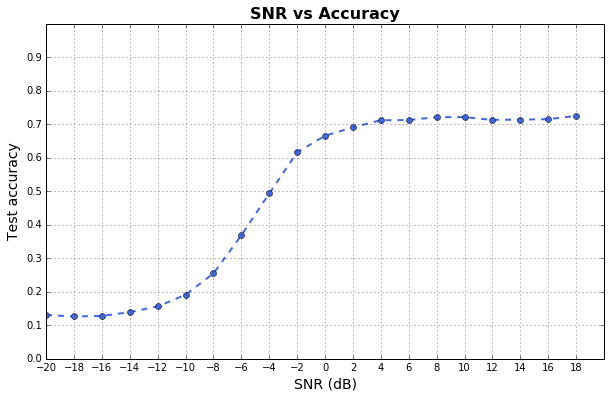

In [6]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./CNN_2conv_1dense.0.1
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.55  0.01   0.03  0.00  0.00   0.03   0.03  0.34
BPSK   0.00  0.97   0.00  0.00  0.02   0.00   0.00  0.01
CPFSK  0.02  0.00   0.92  0.01  0.00   0.01   0.00  0.04
GFSK   0.02  0.01   0.01  0.95  0.00   0.00   0.00  0.01
PAM4   0.00  0.02   0.00  0.00  0.97   0.01   0.01  0.00
QAM16  0.07  0.00   0.00  0.00  0.02   0.44   0.43  0.04
QAM64  0.04  0.01   0.00  0.00  0.03   0.42   0.48  0.02
QPSK   0.28  0.07   0.01  0.00  0.00   0.05   0.01  0.58


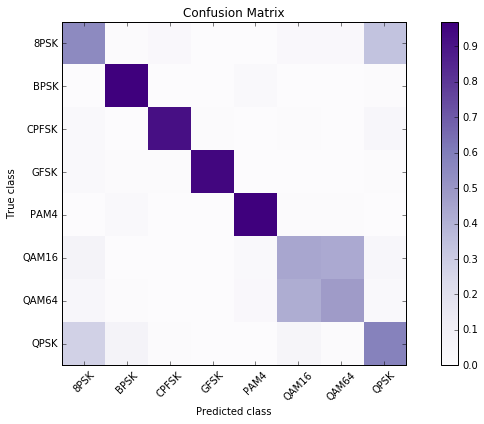

In [7]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_test[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()